## Лабораторная работа №1
Выполнили:<br>
Скрынников Никита<br>
Зиятдинов Азамат<br>

### Дерево решений

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from scipy.optimize import minimize
from sklearn.tree import DecisionTreeRegressor
from math import sqrt
from sklearn.datasets import load_iris
from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

In [2]:
from numpy import inf
def accuracy_score(y_pred, y_test):
    check = [y_pred[i] for i in range(len(y_pred)) if y_pred[i] == y_test[i]]
    return len(check) / len(y_test)

def split_values(a, b, step=None):
    x = a
    step = step if step else (b-a)/100
    count = (b-a)/step
    while a < b:
        yield a
        a += step

props = {}    
        


class DecisionTree(object):
    """
    Дерево решений для классификации
    """
    
    def __init__(self, max_depth, min_size):
        """
        max_depth - maximal tree depth
        min_count - minimal object count in leaf
        """
        self.max_depth = max_depth
        self.min_size = min_size
            

    def gini(self, y):
        """Вычисление индекса Джини
        """
        p = [float(np.sum(y==val))/len(y) for val in np.unique(y)]
        return np.sum([p_i*(1-p_i) for p_i in p])

    
    def division_set(self, index, value, dataset):
        """Разбиение выборки по признаку index в зависимости от value
        """
        left, right = [], []
        for item in dataset:
            if item[index] < value:
                left.append(item)
            else:
                right.append(item)
        return left, right

    
    def get_split(self, dataset, log=False):
        """
        Выбор наилучшего разбиения
        """
        
#         class_values = list(set(row[-1] for row in dataset))
#         b_index, b_value, b_score, b_groups = 999, 999, 999, None
#         for index in range(len(dataset[0])-1):
#             for row in dataset:
#                 group_l, group_r = self.division_set(index, row[index], dataset)
#                 y_l = [x[-1] for x in group_l]
#                 y_r = [x[-1] for x in group_r]
#                 criterion = self._criterion(y_l)+self._criterion(y_r)
#                 if criterion < b_score:
#                     b_index, b_value, b_score, b_groups = index, row[index], criterion, [group_l, group_r]
#         return {'index':b_index, 'value':b_value, 'groups':b_groups}

        
        
        
        
        
        class_values = list(set(item[-1] for item in dataset))
        feature_index, split_value, gini_index, groups = inf, inf, inf, None
        m = len(dataset[0])-1
        indexes = np.random.choice(m, int(sqrt(m))+1, replace=False)
#         print(indexes)

        for index in indexes:
            
#             for item in dataset:
#             a = dataset[index].min()
#             print(a+1, a-1,a)
#             b = dataset[index].max()
#             props['left'] = a
#             props['right'] = b
            props[index] = []
            for item in dataset:

#             for l in split_values(a,b):
                group_l, group_r = self.division_set(index, item[index], dataset)
#                 group_l, group_r = self.division_set(index, l, dataset)

                y_l = [x[-1] for x in group_l]
                y_r = [x[-1] for x in group_r]
                criterion = ((len(y_l))*self.gini(y_l)+(len(y_r))*self.gini(y_r))/(len(y_l) + len(y_r))
#                 print(f'criterion for split {l}: {criterion}')
                props[index].append((item[index], criterion))

                if criterion < gini_index:
                    feature_index, split_value, gini_index, groups = index, item[index], criterion, [group_l, group_r]
                    props[f'{index}_opt'] = item[index]
        return {'feature_index':feature_index, 'value':split_value, 'groups':groups}
    
    
    def node(self, y):
        """
        Создание узла 
        """
        return np.unique(y)[np.argmax([np.sum(y==val) for val in np.unique(y)])]
    

    def _split(self, node, max_depth, min_size, depth):
        """
        Разделение
        """
        left, right = node['groups']
        y_l = [x[-1] for x in left]
        y_r = [x[-1] for x in right]
        del(node['groups'])
        if not left or not right:
            node['left'] = node['right'] = self.node(y_l + y_r)
            return
        if depth >= max_depth:
            node['left'], node['right'] = self.node(y_l), self.node(y_r)
            return
        if len(left) <= min_size:
            node['left'] = self.node(y_l)
        else:
            if(depth==0):
                node['left'] = self.get_split(left, log=True)
            else:
                node['left'] = self.get_split(left)
            self._split(node['left'], max_depth, min_size, depth+1)
        if len(right) <= min_size:
            node['right'] = self.node(y_r)
        else:
            if(depth==0):
                node['right'] = self.get_split(right, log=True)
            else:
                node['right'] = self.get_split(right)


            self._split(node['right'], max_depth, min_size, depth+1)
            

    def get_predict(self, node, item):
        """
        Получение предсказания конкретного узла
        """
        if item[node['feature_index']] < node['value']:
            if isinstance(node['left'], dict):
                return self.get_predict(node['left'], item)
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return self.get_predict(node['right'], item)
            else:
                return node['right']

        
    def fit(self, X, y):
        """
        Обучение дерева
        """
        y.shape = (len(y),1) 
        train = np.append(X, y, axis=1)
        root = self.get_split(train)
        self._split(root, self.max_depth, self.min_size, 1)
        self.tree = root
    
    def predict(self, X):
        predictions = []
        for item in X:
            predict = self.get_predict(self.tree, item)
            predictions.append(predict)
        return(predictions)

### Случайный лес

In [3]:
from IPython.display import clear_output



class RandomForest(object):
    def __init__(self, max_depth=4, min_size=2, n_estimators = 5):
#     def __init__(self, max_depth=2, min_size=1, n_estimators = 5):


        self.trees = [DecisionTree(max_depth=max_depth, min_size=min_size) for _ in range(n_estimators)]
        self.max_depth = max_depth
        self.min_size = min_size
        self.n_estimators = n_estimators
        
    @property
    def size(self):
        return self.n_estimators
    
    def select_features_to_fit(self, x, y): 
        n = len(x)
        x_new = np.array([x[i] for i in range(n)])
        y_new = np.array([y[i] for i in range(n)])
        return (x_new, y_new)
    
    def fit(self, x, y):
        for tree in self.trees:
            new_x, new_y = self.select_features_to_fit(x, y)
            tree.fit(new_x, new_y)

    def predict(self, X):
        result = []
        for tree in self.trees:
            prediction = tree.predict(X)
            if result != []:
                for i in range(len(prediction)):
                    result[i] += prediction[i] / self.size 
            else:
                result = [i / self.size for i in prediction]
        result = [round(item) for item in result]
        return result

    def test(self):
        iris = load_iris()
        X = iris.data
        y = iris.target
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
        self.fit(X_train, y_train)
        test_score = 0
        for tree in self.trees:
            test_score += accuracy_score(y_test, tree.predict(X_test)) / self.size
        print(f"Forest accuracy on test data: {accuracy_score(y_test, self.predict(X_test))}")
        
    def get_accuracy(self, x, y, n):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
        self.trees = []
        self.n_estimators = 0
        res_x = []
        res_y = []
        for i in range(n):
            self.n_estimators += 1
            tree = DecisionTree(max_depth=self.max_depth, min_size=self.min_size)
            self.trees.append(tree)
            tree.fit(X_train, y_train)
            print(f"{i} tree score: {accuracy_score(y_test, tree.predict(X_test))}")
            print(f"{i} forest score: {accuracy_score(y_test, self.predict(X_test))}")


            test_score = accuracy_score(y_test, self.predict(X_test))
            res_x.append(self.size)
            res_y.append(test_score)
        print(y_test)
        print(self.predict(X_test))
        return res_x, res_y

    

In [4]:
def grid_search(classifier, X, y, l, r, step=5):
    if l > r:
        l, r = r, l
    classifiers = []
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    score_res = 0
    cl_res = 0
    for i in range(l, r, step):
        n_estimators = i
        cl = classifier(n_estimators=n_estimators)
        cl.fit(X_train, y_train)
        score = accuracy_score(y_test, cl.predict(X_test))
        if score > score_res:
            score_res = score
            cl_res = cl
        (f"Score {score} with n_estimators={n_estimators}")


    return (cl_res, score_res)

iris = load_iris()
X = iris.data
y = iris.target
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)








Forest accuracy on test data: 0.9333333333333333
dict_keys([0, '0_opt', 1, 3, '3_opt', '1_opt', 2, '2_opt'])
6.7
[(6.7, 0.0), (6.7, 0.0), (6.7, 0.0), (6.8, 0.0), (6.8, 0.0), (6.9, 0.0), (6.9, 0.0), (7.1, 0.0), (7.2, 0.0), (7.2, 0.0), (7.3, 0.0), (7.4, 0.0), (7.6, 0.0), (7.7, 0.0), (7.7, 0.0), (7.7, 0.0), (7.9, 0.0)]


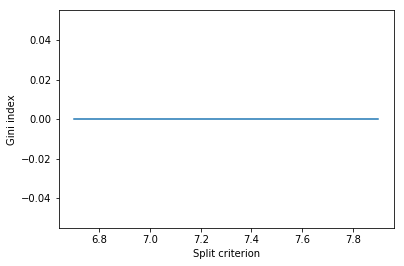

In [5]:
forest = RandomForest()
# grid_search(RandomForest, X, y, 5, 200)
forest.test()
# from display import clear_display

import matplotlib.pyplot as plt
def draw(x,y):

    arr = [(x[i],y[i]) for i in range(len(x))]
    
    arr.sort(key=lambda p: p[0])
    print(arr)
    new_y = [p[1] for p in arr]
    new_x = [p[0] for p in arr]
    
    plt.xlabel('Split criterion')
    plt.ylabel('Gini index')
    plt.plot(new_x, new_y)



print(props.keys())
x = [item[0] for item in props[0]]
y = [item[1] for item in props[0]]
print(props['0_opt'])
draw(x,y)




[(6.7, 0.0), (6.7, 0.0), (6.7, 0.0), (6.8, 0.0), (6.8, 0.0), (6.9, 0.0), (6.9, 0.0), (7.1, 0.0), (7.2, 0.0), (7.2, 0.0), (7.3, 0.0), (7.4, 0.0), (7.6, 0.0), (7.7, 0.0), (7.7, 0.0), (7.7, 0.0), (7.9, 0.0)]
[(6.7, 0.0), (6.7, 0.0), (6.7, 0.0), (6.8, nan), (6.9, 0.0), (6.9, -0.0), (7.1, 0.0), (7.2, 0.0), (7.2, -0.0), (7.3, 0.0), (7.4, 0.0), (7.6, 0.0), (7.7, -0.0), (7.7, -0.0), (7.7, -0.0), (7.9, -0.0)]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


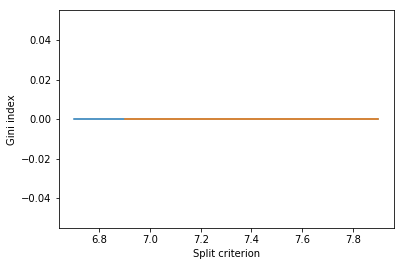

In [6]:
def pretty_draw(x, y, step=4):
    draw(x,y)

def draw_deriv(x, y, power=0):
#     draw(x,y)
    
    y = [(y[i+1]-y[i])/(x[i+1]-x[i]) for i in range(len(y)-1)]
    x = x[:-1]
    if not power:
        draw(x, y)
    else:
        draw_deriv(x, y, power-1)
draw(x, y)
draw_deriv(x,y,0)




3.124500000000001
[(2.6, 0.0), (2.8, 0.0), (2.8, 0.0), (2.9, 0.0), (3.0, 0.0), (3.0, 0.0), (3.0, 0.0), (3.0, 0.0), (3.1, 0.0), (3.1, 0.0), (3.2, 0.0), (3.2, 0.0), (3.2, 0.0), (3.3, 0.0), (3.6, 0.0), (3.8, 0.0), (3.8, 0.0)]


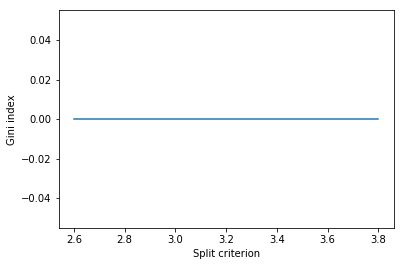

In [7]:
x = [item[0] for item in props[1]]
y = [item[1] for item in props[1]]
print(3.124500000000001)
draw(x, y)

5.1
[(5.1, 0.0), (5.2, 0.0), (5.5, 0.0), (5.6, 0.0), (5.7, 0.0), (5.7, 0.0), (5.9, 0.0), (5.9, 0.0), (6.0, 0.0), (6.1, 0.0), (6.1, 0.0), (6.3, 0.0), (6.4, 0.0), (6.6, 0.0), (6.7, 0.0), (6.7, 0.0), (6.9, 0.0)]


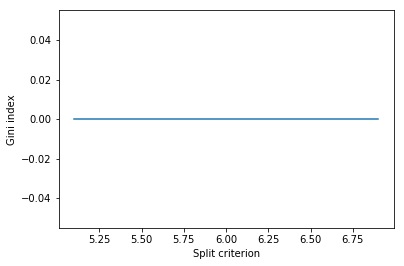

In [8]:
print(props['2_opt'])
x = [item[0] for item in props[2]]
y = [item[1] for item in props[2]]
draw(x, y)


1.7
[(1.8, 0.0), (1.8, 0.0), (1.8, 0.0), (1.8, 0.0), (1.8, 0.0), (1.8, 0.0), (1.8, 0.0), (1.8, 0.0), (1.9, 0.0), (1.9, 0.0), (1.9, 0.0), (2.0, 0.0), (2.0, 0.0), (2.0, 0.0), (2.1, 0.0), (2.2, 0.0), (2.3, 0.0), (2.3, 0.0), (2.4, 0.0)]


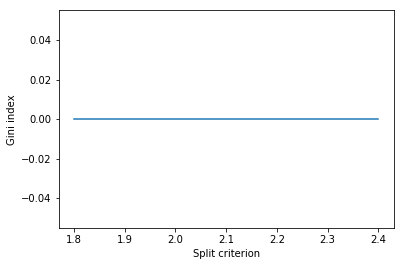

In [9]:
print(props['3_opt'])
x = [item[0] for item in props[3]]
y = [item[1] for item in props[3]]
draw(x, y)

In [10]:
def plot_accuracy(classifier, X, y, l, r, step=25):
    if l > r:
        l, r = r, l
    classifiers = []
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    score_res = 0
    cl_res = 0
    x_res = []
    y_res = []
    for i in range(l, r, step):
        x_res.append(i)
        cl = classifier(n_estimators=i)
        cl.fit(X_train, y_train)
        score = accuracy_score(y_test, cl.predict(X_test))
        y_res.append(score)
    return x_res, y_res



0 tree score: 0.9
0 forest score: 0.9
1 tree score: 0.8333333333333334
1 forest score: 0.8333333333333334
2 tree score: 0.9
2 forest score: 0.9
3 tree score: 0.8666666666666667
3 forest score: 0.8666666666666667
4 tree score: 0.9
4 forest score: 0.9
5 tree score: 0.9
5 forest score: 0.9
6 tree score: 0.9
6 forest score: 0.9
7 tree score: 0.9
7 forest score: 0.9
8 tree score: 0.9
8 forest score: 0.9
9 tree score: 0.8666666666666667
9 forest score: 0.9
10 tree score: 0.9
10 forest score: 0.9
11 tree score: 0.8666666666666667
11 forest score: 0.9
12 tree score: 0.8666666666666667
12 forest score: 0.9
13 tree score: 0.8666666666666667
13 forest score: 0.9
14 tree score: 0.9
14 forest score: 0.9
15 tree score: 0.9
15 forest score: 0.9
16 tree score: 0.8666666666666667
16 forest score: 0.9
17 tree score: 0.9
17 forest score: 0.9
18 tree score: 0.9
18 forest score: 0.9
19 tree score: 0.9
19 forest score: 0.9
20 tree score: 0.8666666666666667
20 forest score: 0.9
21 tree score: 0.8666666666666

172 tree score: 0.8666666666666667
172 forest score: 0.9
173 tree score: 0.9
173 forest score: 0.9
174 tree score: 0.8666666666666667
174 forest score: 0.9
175 tree score: 0.8666666666666667
175 forest score: 0.9
176 tree score: 0.8666666666666667
176 forest score: 0.9
177 tree score: 0.8666666666666667
177 forest score: 0.9
178 tree score: 0.9
178 forest score: 0.9
179 tree score: 0.8666666666666667
179 forest score: 0.9
180 tree score: 0.9
180 forest score: 0.9
181 tree score: 0.9
181 forest score: 0.9
182 tree score: 0.9
182 forest score: 0.9
183 tree score: 0.9
183 forest score: 0.9
184 tree score: 0.8666666666666667
184 forest score: 0.9
185 tree score: 0.9
185 forest score: 0.9
186 tree score: 0.9
186 forest score: 0.9
187 tree score: 0.9
187 forest score: 0.9
188 tree score: 0.8666666666666667
188 forest score: 0.9
189 tree score: 0.8666666666666667
189 forest score: 0.9
190 tree score: 0.8666666666666667
190 forest score: 0.9
191 tree score: 0.8666666666666667
191 forest score:

339 tree score: 0.8666666666666667
339 forest score: 0.9
340 tree score: 0.8666666666666667
340 forest score: 0.9
341 tree score: 0.9
341 forest score: 0.9
342 tree score: 0.8666666666666667
342 forest score: 0.9
343 tree score: 0.8666666666666667
343 forest score: 0.9
344 tree score: 0.9
344 forest score: 0.9
345 tree score: 0.9
345 forest score: 0.9
346 tree score: 0.8666666666666667
346 forest score: 0.9
347 tree score: 0.8666666666666667
347 forest score: 0.9
348 tree score: 0.9
348 forest score: 0.9
349 tree score: 0.9
349 forest score: 0.9
350 tree score: 0.8666666666666667
350 forest score: 0.9
351 tree score: 0.9
351 forest score: 0.9
352 tree score: 0.8666666666666667
352 forest score: 0.9
353 tree score: 0.9
353 forest score: 0.9
354 tree score: 0.9
354 forest score: 0.9
355 tree score: 0.8666666666666667
355 forest score: 0.9
356 tree score: 0.8666666666666667
356 forest score: 0.9
357 tree score: 0.8666666666666667
357 forest score: 0.9
358 tree score: 0.9
358 forest score:

505 tree score: 0.9
505 forest score: 0.9
506 tree score: 0.8666666666666667
506 forest score: 0.9
507 tree score: 0.9
507 forest score: 0.9
508 tree score: 0.9
508 forest score: 0.9
509 tree score: 0.9
509 forest score: 0.9
510 tree score: 0.9
510 forest score: 0.9
511 tree score: 0.9
511 forest score: 0.9
512 tree score: 0.8666666666666667
512 forest score: 0.9
513 tree score: 0.9
513 forest score: 0.9
514 tree score: 0.9
514 forest score: 0.9
515 tree score: 0.9
515 forest score: 0.9
516 tree score: 0.9
516 forest score: 0.9
517 tree score: 0.9
517 forest score: 0.9
518 tree score: 0.8666666666666667
518 forest score: 0.9
519 tree score: 0.8666666666666667
519 forest score: 0.9
520 tree score: 0.9
520 forest score: 0.9
521 tree score: 0.8666666666666667
521 forest score: 0.9
522 tree score: 0.9
522 forest score: 0.9
523 tree score: 0.8666666666666667
523 forest score: 0.9
524 tree score: 0.9
524 forest score: 0.9
525 tree score: 0.8666666666666667
525 forest score: 0.9
526 tree scor

674 tree score: 0.9
674 forest score: 0.9
675 tree score: 0.8666666666666667
675 forest score: 0.9
676 tree score: 0.9
676 forest score: 0.9
677 tree score: 0.8666666666666667
677 forest score: 0.9
678 tree score: 0.8666666666666667
678 forest score: 0.9
679 tree score: 0.8333333333333334
679 forest score: 0.9
680 tree score: 0.8666666666666667
680 forest score: 0.9
681 tree score: 0.9
681 forest score: 0.9
682 tree score: 0.8333333333333334
682 forest score: 0.9
683 tree score: 0.8666666666666667
683 forest score: 0.9
684 tree score: 0.9
684 forest score: 0.9
685 tree score: 0.9
685 forest score: 0.9
686 tree score: 0.8666666666666667
686 forest score: 0.9
687 tree score: 0.9
687 forest score: 0.9
688 tree score: 0.9
688 forest score: 0.9
689 tree score: 0.9
689 forest score: 0.9
690 tree score: 0.8666666666666667
690 forest score: 0.9
691 tree score: 0.9
691 forest score: 0.9
692 tree score: 0.9
692 forest score: 0.9
693 tree score: 0.8666666666666667
693 forest score: 0.9
694 tree s

840 tree score: 0.9
840 forest score: 0.9
841 tree score: 0.8666666666666667
841 forest score: 0.9
842 tree score: 0.9
842 forest score: 0.9
843 tree score: 0.9
843 forest score: 0.9
844 tree score: 0.9
844 forest score: 0.9
845 tree score: 0.9
845 forest score: 0.9
846 tree score: 0.8666666666666667
846 forest score: 0.9
847 tree score: 0.9
847 forest score: 0.9
848 tree score: 0.9
848 forest score: 0.9
849 tree score: 0.8666666666666667
849 forest score: 0.9
850 tree score: 0.8666666666666667
850 forest score: 0.9
851 tree score: 0.8666666666666667
851 forest score: 0.9
852 tree score: 0.8666666666666667
852 forest score: 0.9
853 tree score: 0.9
853 forest score: 0.9
854 tree score: 0.9
854 forest score: 0.9
855 tree score: 0.9
855 forest score: 0.9
856 tree score: 0.9
856 forest score: 0.9
857 tree score: 0.9
857 forest score: 0.9
858 tree score: 0.8666666666666667
858 forest score: 0.9
859 tree score: 0.8666666666666667
859 forest score: 0.9
860 tree score: 0.8666666666666667
860 f

1007 tree score: 0.9
1007 forest score: 0.9
1008 tree score: 0.8666666666666667
1008 forest score: 0.9
1009 tree score: 0.9
1009 forest score: 0.9
1010 tree score: 0.8666666666666667
1010 forest score: 0.9
1011 tree score: 0.8666666666666667
1011 forest score: 0.9
1012 tree score: 0.9
1012 forest score: 0.9
1013 tree score: 0.8666666666666667
1013 forest score: 0.9
1014 tree score: 0.9
1014 forest score: 0.9
1015 tree score: 0.9
1015 forest score: 0.9
1016 tree score: 0.8666666666666667
1016 forest score: 0.9
1017 tree score: 0.8666666666666667
1017 forest score: 0.9
1018 tree score: 0.9
1018 forest score: 0.9
1019 tree score: 0.8666666666666667
1019 forest score: 0.9
1020 tree score: 0.9
1020 forest score: 0.9
1021 tree score: 0.9
1021 forest score: 0.9
1022 tree score: 0.9
1022 forest score: 0.9
1023 tree score: 0.8666666666666667
1023 forest score: 0.9
1024 tree score: 0.9
1024 forest score: 0.9
1025 tree score: 0.8666666666666667
1025 forest score: 0.9
1026 tree score: 0.8666666666

1167 tree score: 0.9
1167 forest score: 0.9
1168 tree score: 0.8666666666666667
1168 forest score: 0.9
1169 tree score: 0.8666666666666667
1169 forest score: 0.9
1170 tree score: 0.8666666666666667
1170 forest score: 0.9
1171 tree score: 0.8666666666666667
1171 forest score: 0.9
1172 tree score: 0.9
1172 forest score: 0.9
1173 tree score: 0.9
1173 forest score: 0.9
1174 tree score: 0.8666666666666667
1174 forest score: 0.9
1175 tree score: 0.9
1175 forest score: 0.9
1176 tree score: 0.9333333333333333
1176 forest score: 0.9
1177 tree score: 0.8666666666666667
1177 forest score: 0.9
1178 tree score: 0.9
1178 forest score: 0.9
1179 tree score: 0.8666666666666667
1179 forest score: 0.9
1180 tree score: 0.8666666666666667
1180 forest score: 0.9
1181 tree score: 0.8666666666666667
1181 forest score: 0.9
1182 tree score: 0.9
1182 forest score: 0.9
1183 tree score: 0.9
1183 forest score: 0.9
1184 tree score: 0.8666666666666667
1184 forest score: 0.9
1185 tree score: 0.8666666666666667
1185 fo

1324 tree score: 0.9
1324 forest score: 0.9
1325 tree score: 0.9
1325 forest score: 0.9
1326 tree score: 0.8666666666666667
1326 forest score: 0.9
1327 tree score: 0.9
1327 forest score: 0.9
1328 tree score: 0.8666666666666667
1328 forest score: 0.9
1329 tree score: 0.9
1329 forest score: 0.9
1330 tree score: 0.8666666666666667
1330 forest score: 0.9
1331 tree score: 0.9
1331 forest score: 0.9
1332 tree score: 0.9
1332 forest score: 0.9
1333 tree score: 0.9
1333 forest score: 0.9
1334 tree score: 0.8666666666666667
1334 forest score: 0.9
1335 tree score: 0.9
1335 forest score: 0.9
1336 tree score: 0.9
1336 forest score: 0.9
1337 tree score: 0.9
1337 forest score: 0.9
1338 tree score: 0.9
1338 forest score: 0.9
1339 tree score: 0.9
1339 forest score: 0.9
1340 tree score: 0.8666666666666667
1340 forest score: 0.9
1341 tree score: 0.9
1341 forest score: 0.9
1342 tree score: 0.8666666666666667
1342 forest score: 0.9
1343 tree score: 0.9
1343 forest score: 0.9
1344 tree score: 0.9
1344 fore

1483 tree score: 0.8666666666666667
1483 forest score: 0.9
1484 tree score: 0.8666666666666667
1484 forest score: 0.9
1485 tree score: 0.8666666666666667
1485 forest score: 0.9
1486 tree score: 0.9
1486 forest score: 0.9
1487 tree score: 0.8666666666666667
1487 forest score: 0.9
1488 tree score: 0.9
1488 forest score: 0.9
1489 tree score: 0.8666666666666667
1489 forest score: 0.9
1490 tree score: 0.8666666666666667
1490 forest score: 0.9
1491 tree score: 0.9
1491 forest score: 0.9
1492 tree score: 0.8666666666666667
1492 forest score: 0.9
1493 tree score: 0.9
1493 forest score: 0.9
1494 tree score: 0.9
1494 forest score: 0.9
1495 tree score: 0.8666666666666667
1495 forest score: 0.9
1496 tree score: 0.8666666666666667
1496 forest score: 0.9
1497 tree score: 0.8666666666666667
1497 forest score: 0.9
1498 tree score: 0.8666666666666667
1498 forest score: 0.9
1499 tree score: 0.9
1499 forest score: 0.9
[0 1 2 1 2 2 0 0 2 1 0 2 0 2 2 2 2 1 1 1 1 2 0 2 2 2 2 2 1 1]
[0.0, 1.0, 2.0, 1.0, 2.0,

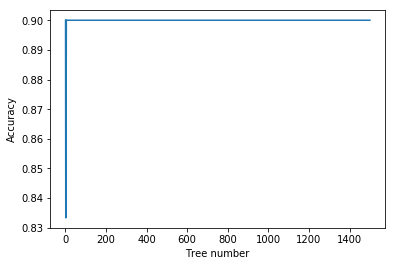

In [20]:
X = iris.data
y = iris.target
forest = RandomForest()

x_acc, y_acc = forest.get_accuracy(X, y, 1500)
plt.xlabel('Tree number')
plt.ylabel('Accuracy')
plt.plot(x_acc, y_acc)




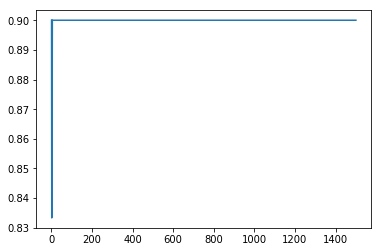

In [21]:
plt.plot(x_acc, y_acc)



In [19]:
y = [0, 1, 0, 2, 1, 0, 0, 1, 1, 2, 0, 2, 1, 1, 0, 2, 1, 2, 0, 0, 1, 2, 2, 0, 0, 2, 2, 2, 1, 0]
y_pred = [0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, 0.0, 2.0, 2.0, 2.0, 1.0, 0.0]
for i in range(len(y_pred)):
    if y_pred[i] != y[i]:
        print(f'{i}   {y_pred[i]}; {y[i]}')
print(len(y_pred))

15   1.0; 2
30
